# Mini-Project (ML for Time Series) - MVA 2023/2024
## Antoine Ratouchniak - antoine.ratouchniak@ens-paris-saclay.fr
## Hugo Queniat - hugo.queniat@telecom-paris.fr

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ruptures
from metrics import DefaultMetrics
import pandas as pd
from algorithms.median_method.median_method import MedianMethod as median
from algorithms.fft.fft import FFT as fft_algo
from algorithms.ps_svm.ps_svm import PS_SVM as ps_svm
from algorithms.lof.lof import LOF as lof
import os
import tqdm

In [ ]:
def longest_subsequences(arr):
    # returns the longest subsequences given an array
    # example longest_subsequences([1, 2, 3, 5, 8, 9, 10]) = [[1, 3], [5], [8, 10]]
    
    result = []
    current_subsequence = [arr[0]]

    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1] + 1:
            current_subsequence.append(arr[i])
        else:
            result.append(current_subsequence)
            current_subsequence = [arr[i]]

    result.append(current_subsequence)
    return result

def plot_signal(t, x, y, save = None):
    plt.plot(t, x)
    indices = np.where(y != 0)[0]
    first = True
    if(sum(indices) == 0):
        print('No anomaly found!')
    else:
        for arr in longest_subsequences(indices):
            plt.gca().add_patch(matplotlib.patches.Rectangle((t[arr[0]], -1), len(arr) * (t[1] - t[0]), 2, color = "red", alpha = 0.25, label = 'anomaly' if first else None))
            first = False

    plt.xlabel('t')
    plt.ylabel('x[t]')
    if(sum(indices) != 0):
        plt.legend()
    plt.tight_layout()
    if(save is not None):
        plt.savefig(save)
    plt.show()

def plot_boxplots(algorithms, roc, save = None, title = 'AUC-ROC'):
    
    # Create a combined DataFrame
    data_combined = pd.DataFrame({'Algorithm': algorithms, title: roc})

    # Plot using Seaborn
    sns_plot = sns.boxplot(x=title, y='Algorithm', data=data_combined, 
                boxprops=dict(edgecolor="#158", facecolor="None"),
                medianprops=dict(color="orange"),
                meanprops=dict(markerfacecolor="green", markeredgecolor="green"), 
                flierprops=dict(markerfacecolor="black", markeredgecolor="black", marker="o", markersize=5),
                showmeans=True,
                meanline=True,
                showfliers=True, width = 0.3)
    
    for i in range(1, len(set(data_combined['Algorithm']))):
        plt.axhline(i - 0.5, color='black', linestyle='--', linewidth=1)
        
    plt.tight_layout()
    if(save):
        plt.savefig(save)
    #sns_plot.figure.savefig("output.png")
    plt.show()

In [ ]:
md = median()
ft = fft_algo()
ps = ps_svm()
lf = lof()

In [ ]:
frequencies_datasets = {'Dodgers/':499,
              'NAB/':15,
              'NASA-MSL/':15,
              'NASA-SMAP/':15,
              'NormA/':250}
frequencies = []

data = []
labels = []
datasets = ['Dodgers/',
           'NAB/',
           'NASA-MSL/',
           'NASA-SMAP/',
           'NormA/']
for dataset in tqdm.tqdm(datasets, desc = 'reading datasets'):
    for file in os.listdir('univariate/'+dataset):
        if('.csv' in file):
            f = pd.read_csv('univariate/'+dataset+file).to_numpy()
            data.append(f[:, 1].astype(float))
            labels.append(f[:, 2].astype(int))
            frequencies.append(frequencies_datasets[dataset])

reading datasets: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


In [ ]:
def evaluate(algo, indicate_freq = False, *args, **kwargs):
    roc = []
    pr = []
    for i, (x, y) in enumerate(tqdm.tqdm(zip(data, labels), desc = 'dataset')):
        if(indicate_freq):
            y_pred = algo.evaluate(x, fs = frequencies[i], *args, **kwargs)
        else:
            y_pred = algo.evaluate(x, *args, **kwargs)
        roc_auc = np.nan_to_num(DefaultMetrics.ROC_AUC(y, y_pred.astype(float)))
        pr_auc = np.nan_to_num(DefaultMetrics.PR_AUC(y, y_pred.astype(float)))
        roc.append(roc_auc)
        pr.append(pr_auc)
    return roc, pr

# The Median method

In [ ]:
roc_median, pr_median = evaluate(md, neighborhood_size = 50)

dataset: 242it [00:01, 174.44it/s]


In [ ]:
roc_median_ms, pr_median_ms = evaluate(md, neighborhood_size = 50, multi_scale = True)

dataset: 242it [00:01, 141.49it/s]


In [ ]:
algo_combined = []
for algo in algorithms[:2]:
    algo_combined += [algo] * len(roc_median)

In [ ]:
print('-' * 10 + ' Median ' + '-' * 10)
print('ROC')
print('Median:',np.median(roc_median).round(2), np.median(roc_median_ms).round(2))
print('Mean:',np.mean(roc_median).round(2), np.mean(roc_median_ms).round(2))
print('PR')
print('Median:',np.median(pr_median).round(2), np.median(pr_median_ms).round(2))
print('Mean:',np.mean(pr_median).round(2), np.mean(pr_median_ms).round(2))

---------- Median ----------
ROC
Median: 0.47 0.48
Mean: 0.36 0.38
PR
Median: 0.24 0.26
Mean: 0.29 0.3


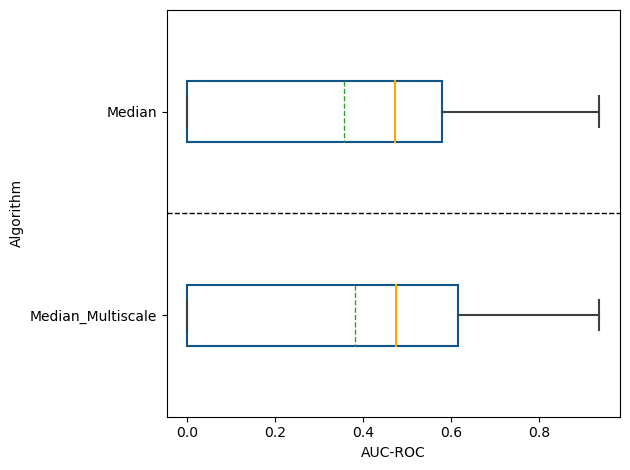

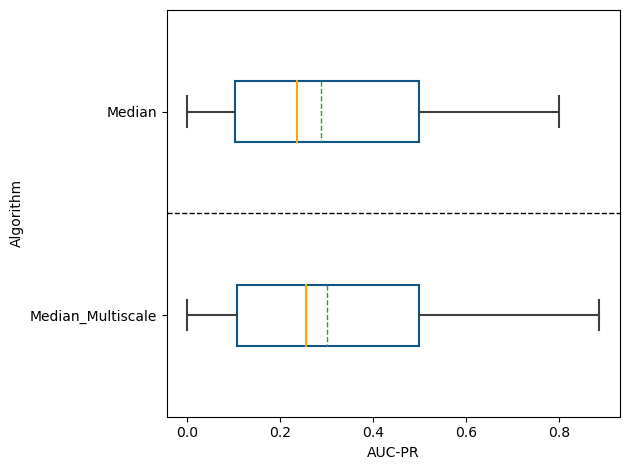

In [ ]:
plot_boxplots(algo_combined, roc_median + roc_median_ms, save = 'median_roc.pdf')
plot_boxplots(algo_combined, pr_median + pr_median_ms, title = 'AUC-PR', save = 'median_pr.pdf')

### Toy dataset

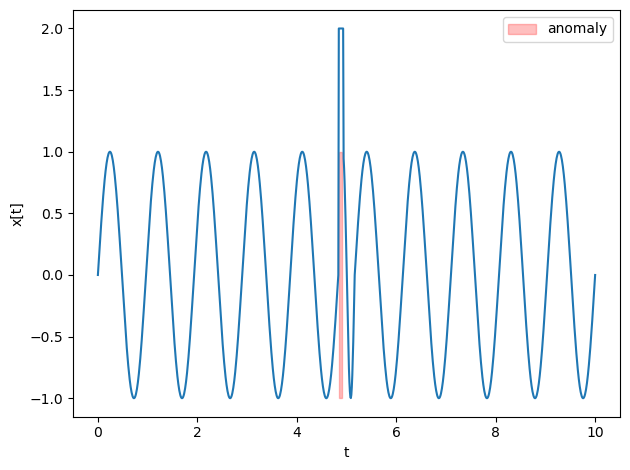

In [ ]:
fs = 100
f = 100
n = 5
x = np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)
f = 300
n = 1
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)[:fs//3]))
f = 100
n = 5
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)))

x[500:510] = 2

y_pred = md.evaluate(x.reshape(-1,), neighborhood_size = 100)
y_pred = y_pred > np.quantile(y_pred, .99)
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred)

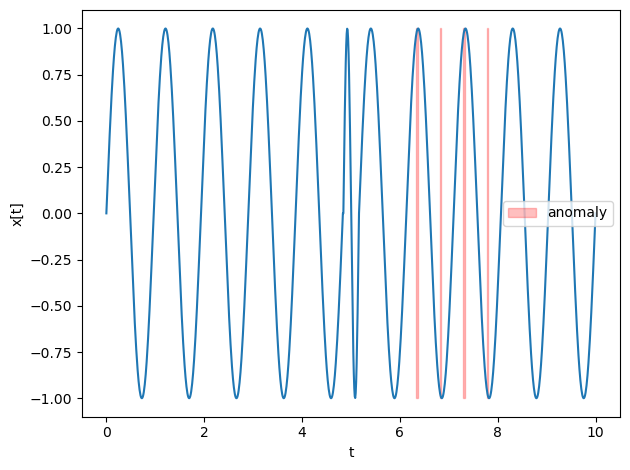

In [ ]:
fs = 100
f = 100
n = 5
x = np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)
f = 300
n = 1
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)[:fs//3]))
f = 100
n = 5
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)))

#x[500:510] = 2

y_pred = md.evaluate(x.reshape(-1,), neighborhood_size = 100)
y_pred = y_pred > np.quantile(y_pred, .99)
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred)

# FFTBSOM

We explore 3 preprocessing techniques to reduce noise:
- Moving average:
$$x[t] = \frac{x[t - N / 2] + \dots + x[t] + \dots + x[t + N / 2 - 1]}{N}$$
- The dictionary learning is a Lasso regression as shown in class:
$$\underset{z}{\arg\min} \frac{1}{2} \lVert x - Dz \rVert_2^2 + \lambda \lVert z \rVert_1$$
where $x$ is the input signal, $D$ is the dictionary, $\lambda$ a regularization parameter and $z$ the sparse representation. One could use a grid-search to find an optimal $\lambda$ but we do not do it in this work due to computational limitations.
- Savitzky-Golay filter:
[https://pubs.acs.org/doi/pdf/10.1021/ac60214a047](Savitzky, A., & Golay, M. J. (1964). Smoothing and differentiation of data by simplified least squares procedures. Analytical chemistry, 36(8), 1627-1639.)

In [ ]:
roc_fft, pr_fft = evaluate(ft)

dataset: 242it [09:56,  2.47s/it]


In [ ]:
np.save('roc_fft', roc_fft)
np.save('pr_fft', pr_fft)

In [ ]:
roc_fft_p1, pr_fft_p1 = evaluate(ft, preprocessing = 1)

dataset: 242it [00:25,  9.47it/s]


In [ ]:
roc_fft_p2, pr_fft_p2 = evaluate(ft, indicate_freq = True, preprocessing = 2)

dataset: 242it [18:08,  4.50s/it]


In [ ]:
np.save('roc_fft_p2', roc_fft)
np.save('pr_fft_p2', pr_fft)

In [ ]:
roc_fft_p3, pr_fft_p3 = evaluate(ft, preprocessing = 3)

dataset: 242it [00:28,  8.52it/s]


In [ ]:
algo_combined = []
for algo in algorithms[2:6]:
    algo_combined += [algo] * len(roc_fft)

In [ ]:
print('-' * 10 + ' FFT ' + '-' * 10)
print('ROC')
print('Median:',np.median(roc_fft).round(2), np.median(roc_fft_p1).round(2),
      np.median(roc_fft_p2).round(2), np.median(roc_fft_p3).round(2))
print('Mean:',np.mean(roc_fft).round(2), np.mean(roc_fft_p1).round(2),
      np.mean(roc_fft_p2).round(2), np.mean(roc_fft_p3).round(2))
print('PR')
print('Median:',np.median(pr_fft).round(2), np.median(pr_fft_p1).round(2),
     np.median(pr_fft_p2).round(2), np.median(pr_fft_p3).round(2))
print('Mean:',np.mean(pr_fft).round(2), np.mean(pr_fft_p1).round(2),
     np.mean(pr_fft_p2).round(2), np.mean(pr_fft_p3).round(2))

---------- FFT ----------
ROC
Median: 0.0 0.4 0.0 0.46
Mean: 0.25 0.29 0.12 0.33
PR
Median: 0.3 0.24 0.0 0.36
Mean: 0.28 0.28 0.19 0.3


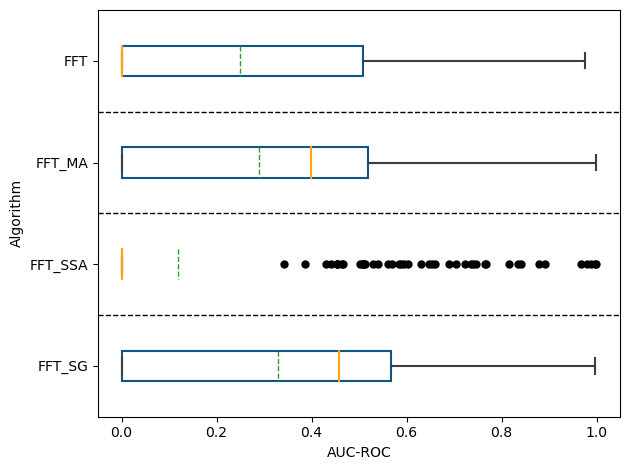

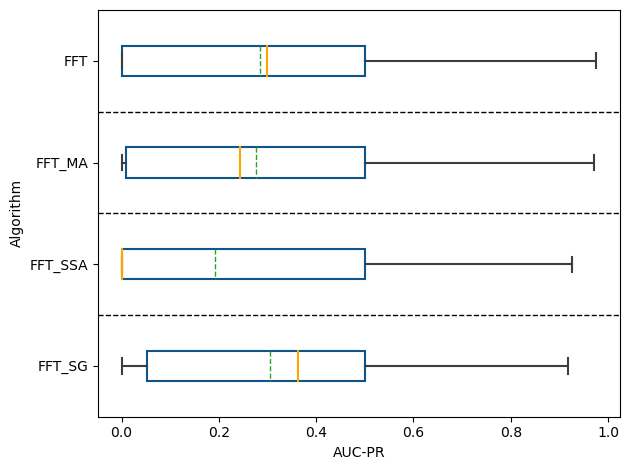

In [ ]:
plot_boxplots(algo_combined, roc_fft + roc_fft_p1 + list(roc_fft_p2) + roc_fft_p3, save = 'fft_roc.pdf')
splot_boxplots(algo_combined, pr_fft + pr_fft_p1 + list(pr_fft_p2) + pr_fft_p3, title = 'AUC-PR', save = 'fft_pr.pdf')

### Toy dataset

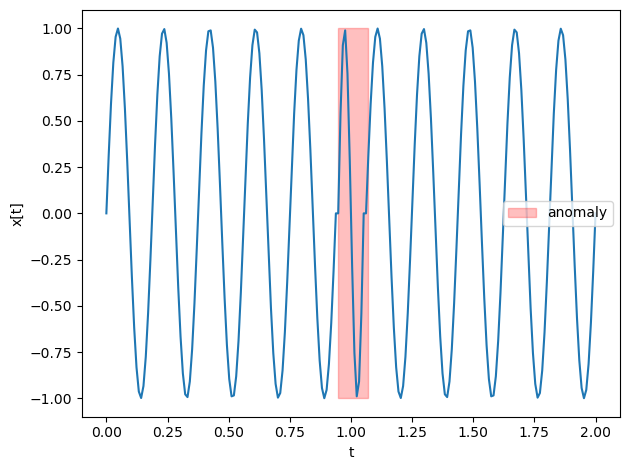

In [ ]:
fs = 100
f = 100
n = 5
x = np.sin(2 * np.pi * f * np.linspace(0, n, fs) / fs)
f = 300
n = 1
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n * (f // fs), fs) / fs)[:fs//8]))
f = 100
n = 5
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, fs) / fs)))

y_pred = ft.evaluate(x.reshape(-1,))
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'fft.pdf')

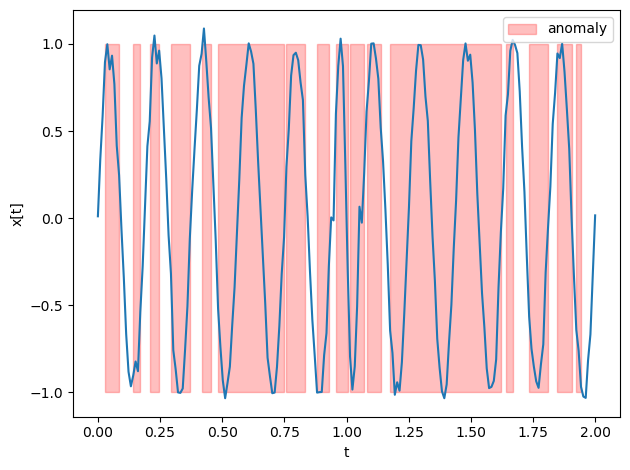

In [ ]:
fs = 100
f = 100
n = 5
x = np.sin(2 * np.pi * f * np.linspace(0, n, fs) / fs)
f = 300
n = 1
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n * (f // fs), fs) / fs)[:fs//8]))
f = 100
n = 5
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, fs) / fs)))
x += 0.05 * np.random.randn(len(x)) # adding noise

y_pred = ft.evaluate(x.reshape(-1,))
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'fft_noisy.pdf')

# PS-SVM

In [ ]:
roc_pssvm, pr_pssvm = evaluate(ps, embed_dims = [3])

dataset: 242it [05:11,  1.29s/it]


In [ ]:
np.save('roc_pssvm', roc_pssvm)
np.save('pr_pssvm', pr_pssvm)

In [ ]:
roc_pssvm_d2, pr_pssvm_d2 = evaluate(ps, embed_dims = [3, 5])

dataset: 242it [10:03,  2.50s/it]


In [ ]:
np.save('roc_pssvm_d2', roc_pssvm_d2)
np.save('pr_pssvm_d2', pr_pssvm_d2)

In [ ]:
roc_pssvm_d3, pr_pssvm_d3 = evaluate(ps, embed_dims = [3, 5, 7])

dataset: 242it [15:04,  3.74s/it]


In [ ]:
np.save('roc_pssvm_d3', roc_pssvm_d3)
np.save('pr_pssvm_d3', pr_pssvm_d3)

In [ ]:
roc_pssvm_d4, pr_pssvm_d4 = evaluate(ps, embed_dims = [3, 5, 7, 9])

dataset: 242it [20:46,  5.15s/it]


In [ ]:
np.save('roc_pssvm_d4', roc_pssvm_d4)
np.save('pr_pssvm_d4', pr_pssvm_d4)

In [ ]:
print('-' * 10 + ' PS-SVM ' + '-' * 10)
print('ROC')
print('Median:',np.median(roc_pssvm).round(2), np.median(roc_pssvm_d2).round(2),
      np.median(roc_pssvm_d3).round(2), np.median(roc_pssvm_d4).round(2))
print('Mean:',np.mean(roc_pssvm).round(2), np.mean(roc_pssvm_d2).round(2),
      np.mean(roc_pssvm_d3).round(2), np.mean(roc_pssvm_d4).round(2))
print('PR')
print('Median:',np.median(pr_pssvm).round(2), np.median(pr_pssvm_d2).round(2),
     np.median(pr_pssvm_d3).round(2), np.median(pr_pssvm_d4).round(2))
print('Mean:',np.mean(pr_pssvm).round(2), np.mean(pr_pssvm_d2).round(2),
     np.mean(pr_pssvm_d3).round(2), np.mean(pr_pssvm_d4).round(2))

---------- PS-SVM ----------
ROC
Median: 0.46 0.48 0.49 0.48
Mean: 0.37 0.37 0.37 0.38
PR
Median: 0.46 0.42 0.43 0.45
Mean: 0.36 0.35 0.36 0.37


# Global boxplots

In [ ]:
algorithms = ['Median',
 'Median_Multiscale',
 'FFT',
 'FFT_MA',
 'FFT_SSA',
 'FFT_SG',
 'SR',
 'SR_grid',
 'PSSVM_3', 
 'PSSVM_3,5', 
 'PSSVM_3,5,7',  
 'PSSVM_3,5,7,9',
 'STAMPi',
 'STAMPi_grid',
 'DWT',
 'DWT_Laplace',
 'DWT_T']

In [ ]:
# Hugo's results
roc_sr = list(np.load('regular/SR_regular_ROC.npy'))
pr_sr = list(np.load('regular/SR_regular_PR.npy'))
roc_stmp = list(np.load('regular/STAMPi_regular_PR.npy'))
pr_stmp = list(np.load('regular/STAMPi_regular_ROC.npy'))
roc_dwt = list(np.load('regular/DWT_ROC.npy'))
pr_dwt = list(np.load('regular/DWT_PR.npy'))

roc_sr_grid = list(np.load('improved/SR_ROC.npy'))
pr_sr_grid = list(np.load('improved/SR_PR.npy'))
roc_stmp_grid = list(np.load('improved/STAMPi_PR.npy'))
pr_stmp_grid = list(np.load('improved/STAMPi_ROC.npy'))
roc_dwt_laplace = list(np.load('improved/DWT_Laplace_ROC.npy'))
pr_dwt_laplace = list(np.load('improved/DWT_Laplace_PR.npy'))
roc_dwt_t = list(np.load('improved/DWT_T_ROC.npy'))
pr_dwt_t = list(np.load('improved/DWT_T_PR.npy'))

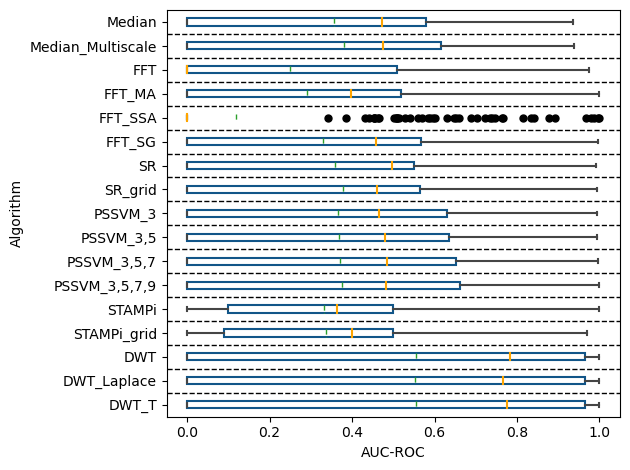

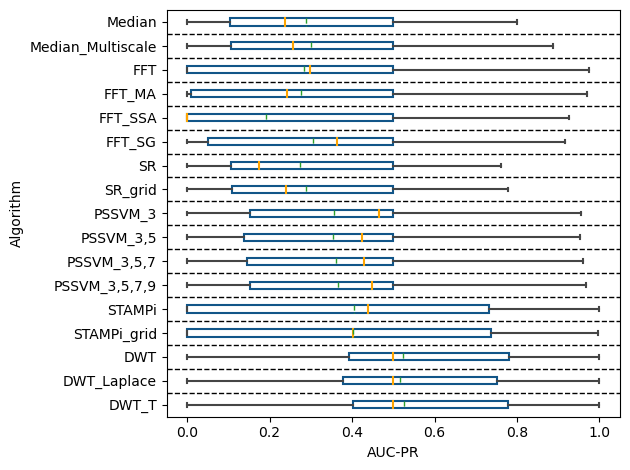

In [ ]:
algo_combined = []
for algo in algorithms:
    algo_combined += [algo] * len(roc_median)
plot_boxplots(algo_combined, roc_median + roc_median_ms +
              roc_fft + roc_fft_p1 + list(roc_fft_p2) + roc_fft_p3 +
              roc_sr + roc_sr_grid +
              roc_pssvm + roc_pssvm_d2 + roc_pssvm_d3 + roc_pssvm_d4 +
              roc_stmp + roc_stmp_grid +
              roc_dwt + roc_dwt_laplace + roc_dwt_t, save = 'roc_results.pdf')
plot_boxplots(algo_combined, pr_median + pr_median_ms +
              pr_fft + pr_fft_p1 + list(pr_fft_p2) + pr_fft_p3 +
              pr_sr + pr_sr_grid +
              pr_pssvm + pr_pssvm_d2 + pr_pssvm_d3 + pr_pssvm_d4 +
              pr_stmp + pr_stmp_grid +
              pr_dwt + pr_dwt_laplace + pr_dwt_t, title = 'AUC-PR', save = 'pr_results.pdf')

# Sub-LOF

We explore three metrics on a toy dataset since computing them on a real dataset is not scalable:
- DTW: [https://seninp.github.io/assets/pubs/senin_dtw_litreview_2008.pdf](Senin, P. (2008). Dynamic time warping algorithm review. Information and Computer Science Department University of Hawaii at Manoa Honolulu, USA, 855(1-23), 40.)
- Soft-DTW: [https://arxiv.org/pdf/1703.01541.pdf](Cuturi, M., & Blondel, M. (2017, July). Soft-dtw: a differentiable loss function for time-series. In International conference on machine learning (pp. 894-903). PMLR.)
- Wasserstein Fourier:
$$\mathbf{WF}_2^2(x, y) = \mathbf{WF}_2^2(s_x, s_y) = \left(\min_{\sigma \in \mathfrak{S}_N} \sum_{i = 1}^N (s_x[i] - s_y[\sigma(i)])^2\right)$$
where $s_x$ and $s_y$ are the normalized power spectral density given by
$s_z(\xi) = \frac{S_z(\xi)}{\sum S_z(\xi)}$ where $z$ is an arbitrary signal.
[https://arxiv.org/pdf/1912.05509.pdf](Cazelles, E., Robert, A., & Tobar, F. (2020). The Wasserstein-Fourier distance for stationary time series. IEEE Transactions on Signal Processing, 69, 709-721.)

Using the default Minkowski metric:

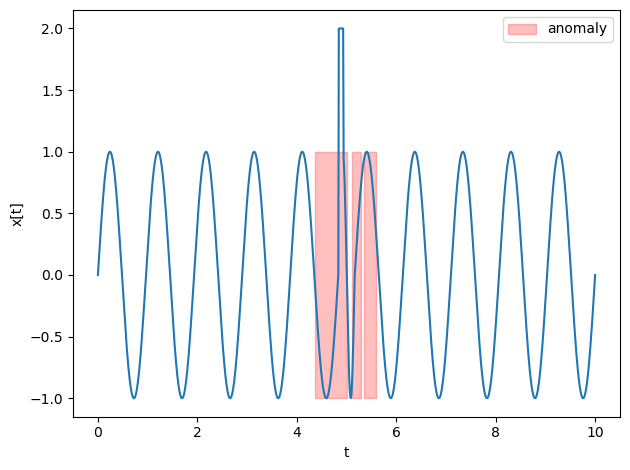

In [ ]:
fs = 100
f = 100
n = 5
x = np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)
f = 300
n = 1
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)[:fs//3]))
f = 100
n = 5
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, n * fs) / fs)))

x[500:510] = 2

y_pred = lf.evaluate(x.reshape(-1,)) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof1_m1.pdf')

Using the DTW:

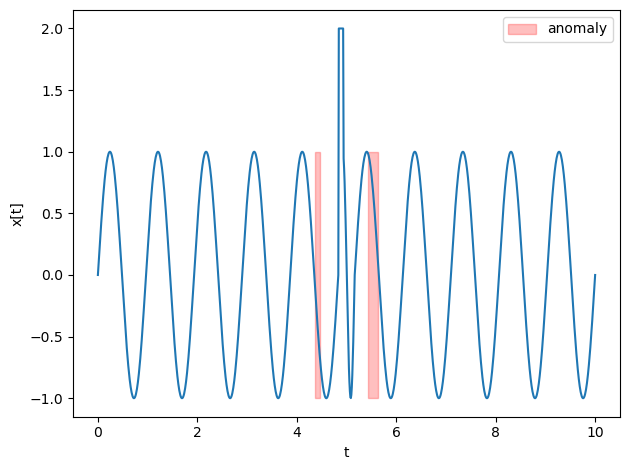

In [ ]:
y_pred = lf.evaluate(x.reshape(-1,), metric = 1) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof1_m2.pdf')

Using the Soft-DTW with $\gamma = 1$:

No anomaly found!


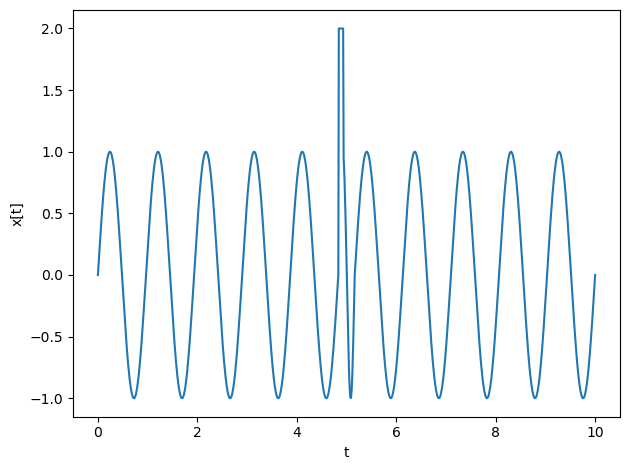

In [ ]:
y_pred = lf.evaluate(x.reshape(-1,), metric = 2) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof1_m3.pdf')

Using the WF:

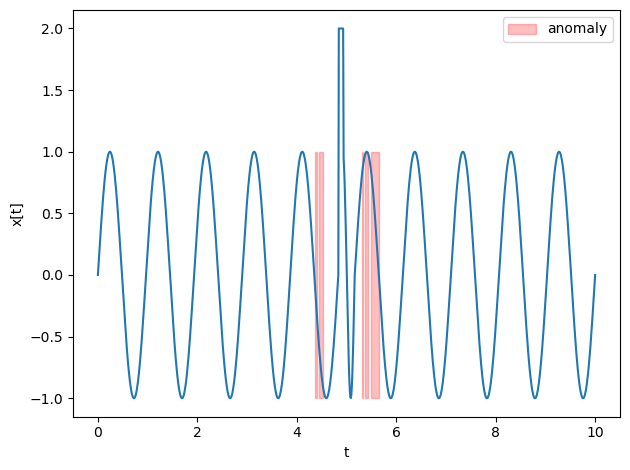

In [ ]:
y_pred = lf.evaluate(x.reshape(-1,), metric = 3) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof1_m4.pdf')

Using Minkowski:

No anomaly found!


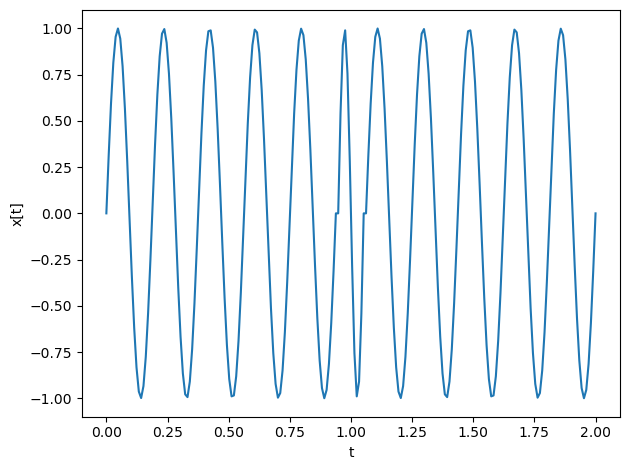

In [ ]:
fs = 100
f = 100
n = 5
x = np.sin(2 * np.pi * f * np.linspace(0, n, fs) / fs)
f = 300
n = 1
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n * (f // fs), fs) / fs)[:fs//8]))
f = 100
n = 5
x = np.concatenate((x, np.sin(2 * np.pi * f * np.linspace(0, n, fs) / fs)))

y_pred = lf.evaluate(x.reshape(-1,)) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof2_m1.pdf')

Using the DTW:

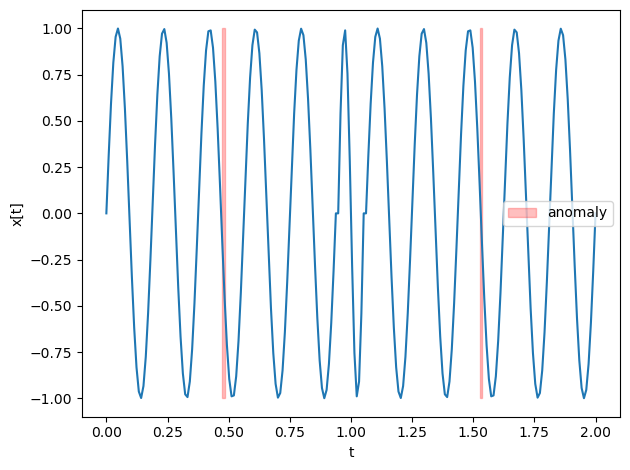

In [ ]:
y_pred = lf.evaluate(x.reshape(-1,), metric = 1) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof2_m2.pdf')

Using the Soft-DTW with $\gamma=1$:

No anomaly found!


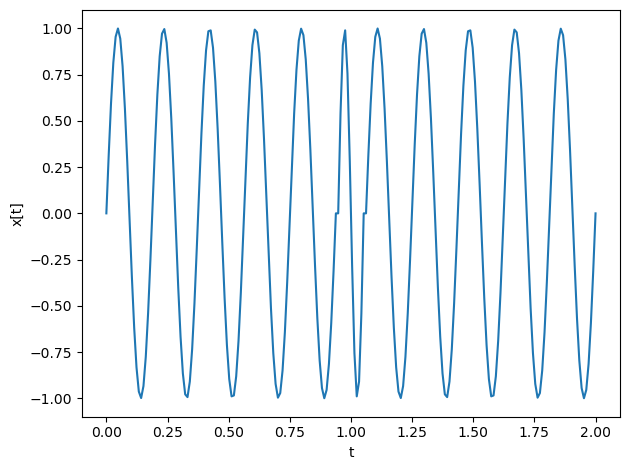

In [ ]:
y_pred = lf.evaluate(x.reshape(-1,), metric = 2) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof2_m3.pdf')

Using the WF:

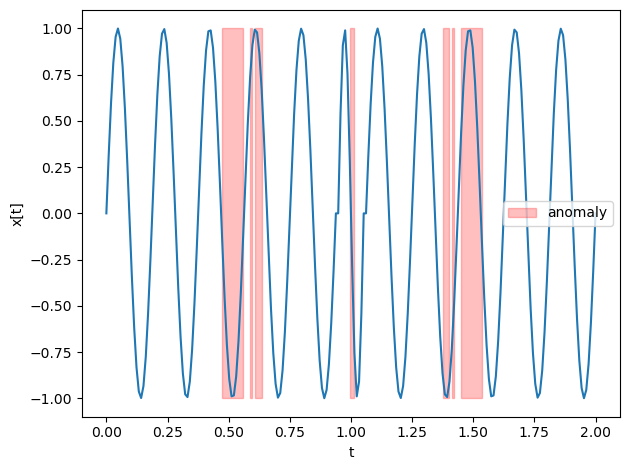

In [ ]:
y_pred = lf.evaluate(x.reshape(-1,), metric = 3) > 0
plot_signal(np.linspace(0, len(x) // fs, len(x)), x, y_pred, save = 'lof2_m4.pdf')

Using Minkowski:

No anomaly found!


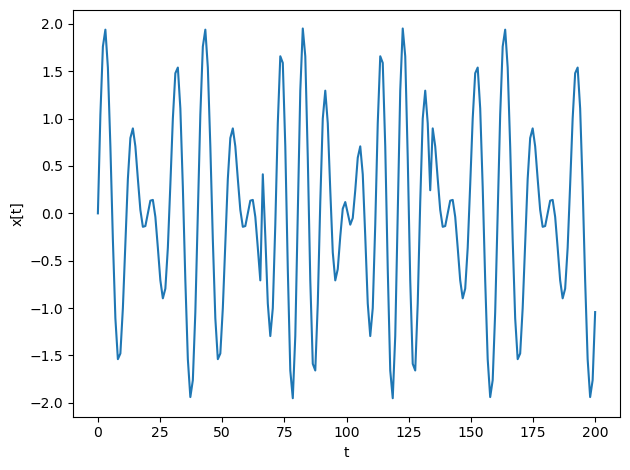

In [ ]:
bkps = 2
wavy = ruptures.datasets.pw_wavy(n_bkps = bkps, noise_std = 0, seed = 0)
y_wavy = wavy[0]
x_wavy = np.zeros(len(wavy[0]))
x_wavy[wavy[1][:bkps]] = 1

y_pred = lf.evaluate(y_wavy.reshape(-1,)) > 0
plot_signal(np.linspace(0, len(y_wavy), len(y_wavy)), y_wavy, y_pred, save = 'lof3_m1.pdf')

Using the DTW:

No anomaly found!


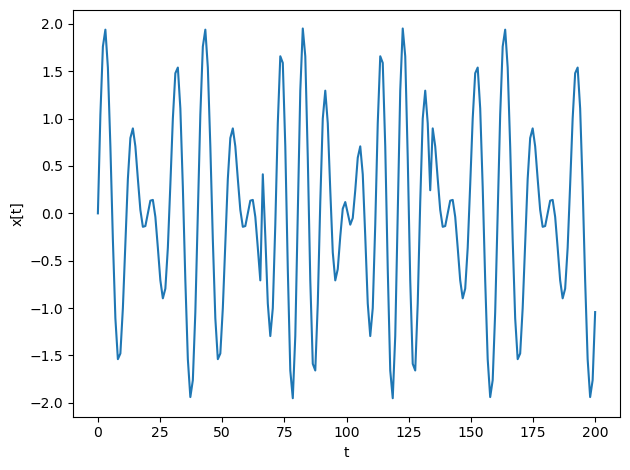

In [ ]:
y_pred = lf.evaluate(y_wavy.reshape(-1,), metric = 1) > 0
plot_signal(np.linspace(0, len(y_wavy), len(y_wavy)), y_wavy, y_pred, save = 'lof3_m2.pdf')

Using the Soft-DTW with $\gamma = 1$:

No anomaly found!


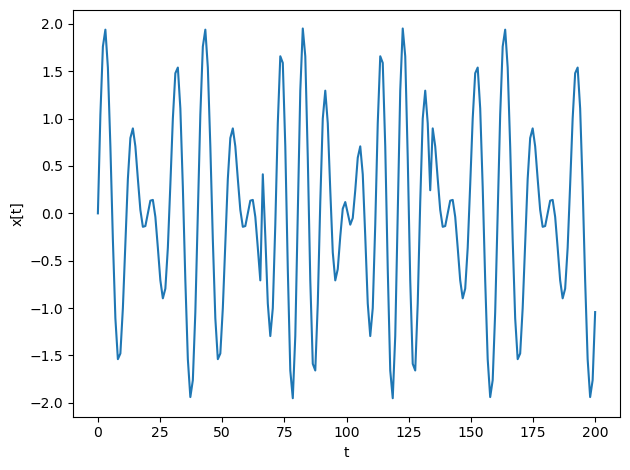

In [ ]:
y_pred = lf.evaluate(y_wavy.reshape(-1,), metric = 2) > 0
plot_signal(np.linspace(0, len(y_wavy), len(y_wavy)), y_wavy, y_pred, save = 'lof3_m3.pdf')

Using the WF:

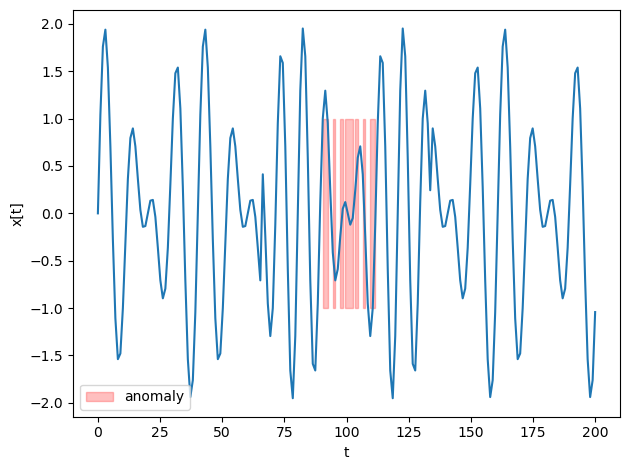

In [ ]:
y_pred = lf.evaluate(y_wavy.reshape(-1,), metric = 3) > 0
plot_signal(np.linspace(0, len(y_wavy), len(y_wavy)), y_wavy, y_pred, save = 'lof3_m4.pdf')